# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error as eval_mse
from sklearn.metrics import median_absolute_error as eval_mae
from scipy.stats import norm
from datetime import datetime
import pandas as pd
pd.options.mode.chained_assignment = None
import json

from load import load_links

print("Numpy Version {}".format(np.__version__))

Numpy Version 1.16.2


# Data Preprocessing

In [4]:
def roll(ix, ts, lags, preds):
    X = np.stack([np.roll(ts, i, axis=0) for i in range(lags, 0, -1)], axis=1)[lags:-preds,]
    Y = np.stack([np.roll(ts, -i, axis=0) for i in range(0, preds, 1)], axis=1)[lags:-preds,]
    Y_ix = ix[lags:-preds]
    return X, Y, Y_ix

def load_data(line, freq, lags, preds):
    train = pd.read_csv(f'Data/{line}_{freq}_train_norm.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    train_counts = pd.read_csv(f'Data/{line}_{freq}_train_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_train, Y_train, Y_train_ix = roll(train.index, train.values, lags, preds)
    
    val = pd.read_csv(f'Data/{line}_{freq}_val_norm.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    val_counts = pd.read_csv(f'Data/{line}_{freq}_val_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_val, Y_val, Y_val_ix = roll(val.index, val.values, lags, preds)

    test = pd.read_csv(f'Data/{line}_{freq}_test_norm.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    test_counts = pd.read_csv(f'Data/{line}_{freq}_test_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    test_mean = pd.read_csv(f'Data/{line}_{freq}_test_mean.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    test_std = pd.read_csv(f'Data/{line}_{freq}_test_std.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_test, Y_test, Y_test_ix = roll(test.index, test.values, lags, preds)
    _, mu_test, _ = roll(test_mean.index, test_mean.values, lags, preds)
    _, sigma_test, _ = roll(test_std.index, test_std.values, lags, preds)
        
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test, Y_test_ix, mu_test, sigma_test)

In [10]:
line = '300S'
freq = '15min'
lags = 32
preds = 3
train_model = True

data_train, data_val, data_test = load_data(line, freq, lags, preds)

# Unpack tensors
(X_train, y_train) = data_train
(X_val, y_val) = data_val
(X_test, y_test, y_ix_test, y_mean_test, y_std_test) = data_test

X_train = X_train
y_train = y_train[..., np.newaxis]
X_val = X_val
y_val = y_val[..., np.newaxis]
X_test = X_test
y_test = y_test

In [11]:
np.save('kalman_test.npy', y_test)

In [12]:
from pykalman import KalmanFilter

In [13]:
kf = KalmanFilter(n_dim_obs=39, n_dim_state=39)

# Training

In [14]:
if train_model:
    kf.em(X_train[:, -1, :])
    for var in kf.em_vars:
        np.save(f'kalman_{var}.npy', getattr(kf, var))
else:
    for var in kf.em_vars:
        setattr(kf, var, np.load(f'kalman_{var}.npy'))

In [15]:
y_test.shape

(1309, 3, 39)

# Prediction

In [16]:
n_timesteps = len(y_test)
n_samples = 500

state_mean = kf.initial_state_mean
state_covariance = kf.initial_state_covariance

transition_matrix = np.eye(kf.n_dim_state)
states = np.zeros((preds, n_samples, kf.n_dim_state))

y_pred_s = np.empty((n_samples,) + y_test.shape)

for t in range(n_timesteps):
    for t_pred in range(preds):
        if t_pred == 0:
            states[t_pred] = np.repeat(state_mean[np.newaxis, ...], n_samples, axis=0)
        else:
            # We skipped np.dot(transition_matrix, states[t - 1]), since transition_matrix is a diagonal
            states[t_pred] = states[t_pred - 1] + np.random.multivariate_normal(np.zeros(kf.n_dim_state), kf.transition_covariance, size=n_samples)
        y_pred_s[:,t,t_pred,:] = states[t_pred] + np.random.multivariate_normal(np.zeros(kf.n_dim_obs), kf.observation_covariance, size=n_samples)
    state_mean, state_covariance = kf.filter_update(state_mean, state_covariance, y_test[t, 0, :])


In [17]:
y_pred_s_all = np.sum(y_pred_s*y_std_test + y_mean_test, axis=3)
eval_quantiles = [0.025, 0.975, 0.05, 0.95, 0.10, 0.90, 0.20, 0.8, 0.4, 0.6]
pred_ints = [0.95,         0.90,       0.80,       0.60,      0.20]
y_pred_q = np.empty((len(eval_quantiles), len(y_test), preds))

for q, quan in enumerate(eval_quantiles):
    y_pred_q[q] = np.quantile(y_pred_s_all, quan, axis=0)

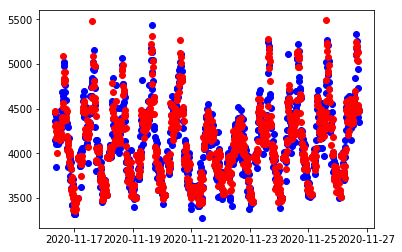

In [18]:
# Predict using mean of samples
y_pred_mean = np.mean(y_pred_s, axis=0)
up_to = 1000
plt.plot(y_ix_test[:up_to], np.sum(y_test[:up_to,0,:]*y_std_test[:up_to,0,:]+y_mean_test[:up_to,0,:], axis=1), 'bo')
plt.plot(y_ix_test[:up_to], np.sum(y_pred_mean[:up_to,0,:]*y_std_test[:up_to,0,:]+y_mean_test[:up_to,0,:], axis=1), 'ro')

Predicting for t + 15 minutes
	Summing over 1 links
		Quantiles [0.025, 0.975]


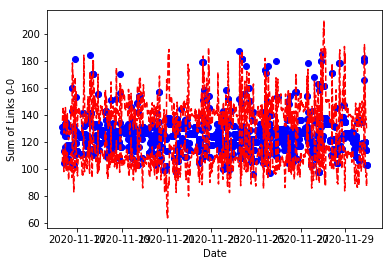

		Quantiles [0.05, 0.95]


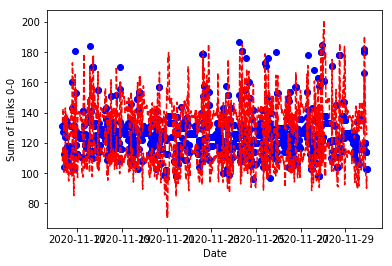

		Quantiles [0.1, 0.9]


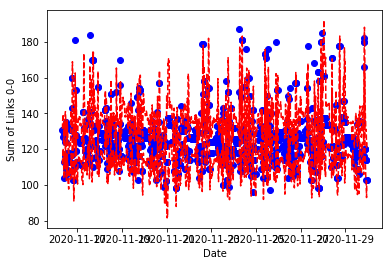

		Quantiles [0.2, 0.8]


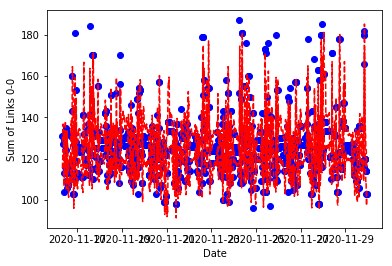

		Quantiles [0.4, 0.6]


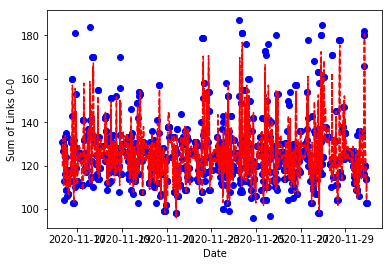

	Summing over 5 links
		Quantiles [0.025, 0.975]


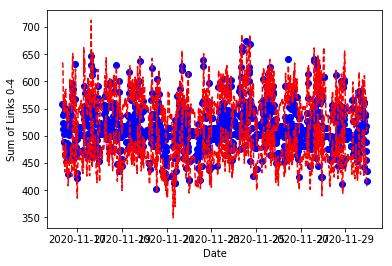

		Quantiles [0.05, 0.95]


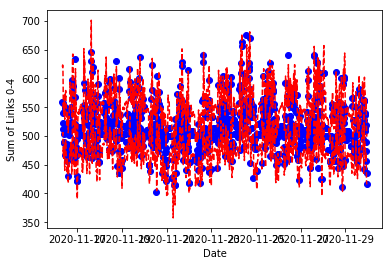

		Quantiles [0.1, 0.9]


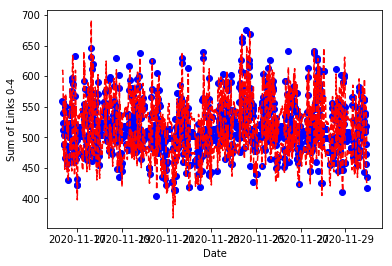

		Quantiles [0.2, 0.8]


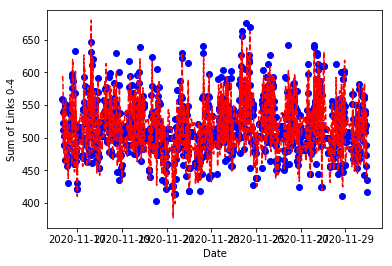

		Quantiles [0.4, 0.6]


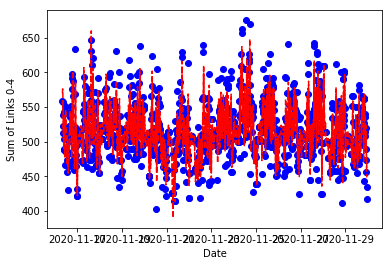

	Summing over 10 links
		Quantiles [0.025, 0.975]


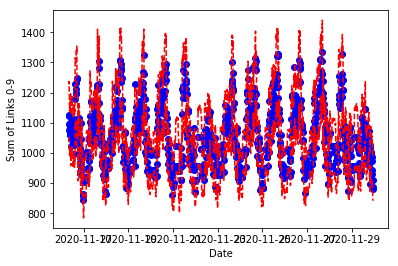

		Quantiles [0.05, 0.95]


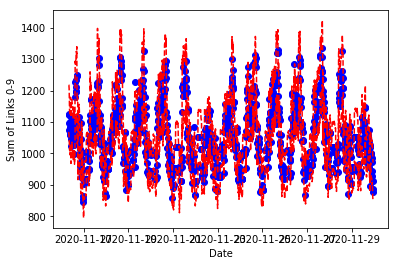

		Quantiles [0.1, 0.9]


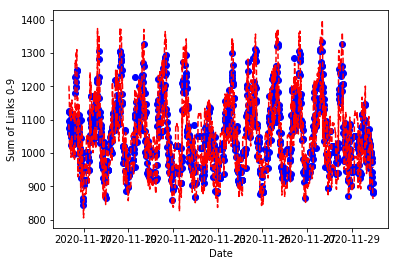

		Quantiles [0.2, 0.8]


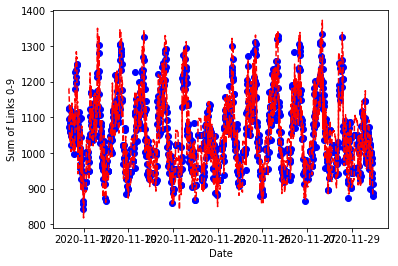

		Quantiles [0.4, 0.6]


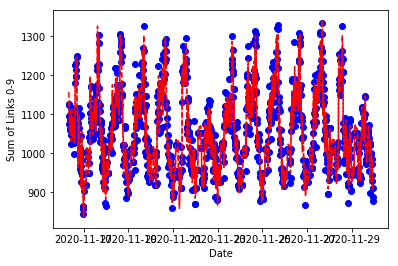

	Summing over 20 links
		Quantiles [0.025, 0.975]


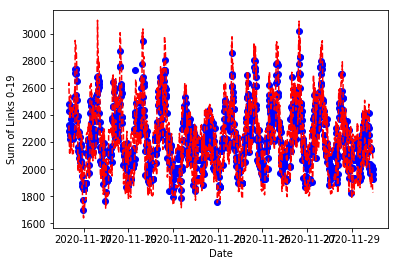

		Quantiles [0.05, 0.95]


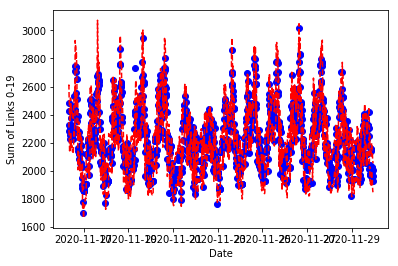

		Quantiles [0.1, 0.9]


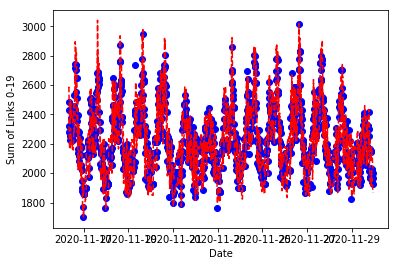

		Quantiles [0.2, 0.8]


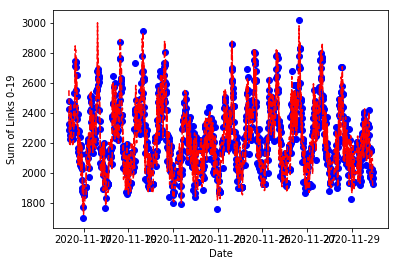

		Quantiles [0.4, 0.6]


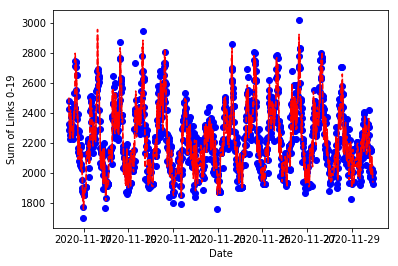

	Summing over 30 links
		Quantiles [0.025, 0.975]


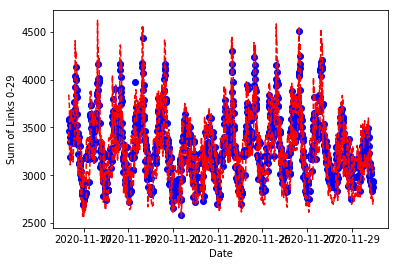

		Quantiles [0.05, 0.95]


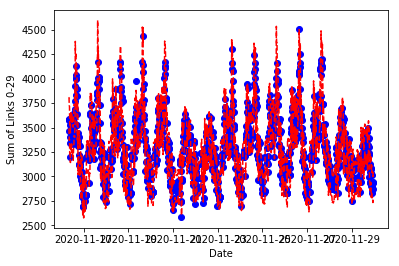

		Quantiles [0.1, 0.9]


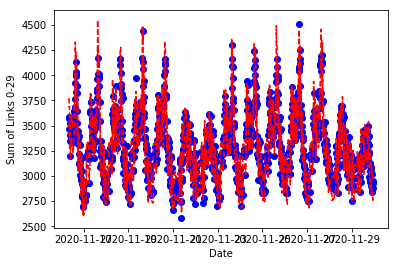

		Quantiles [0.2, 0.8]


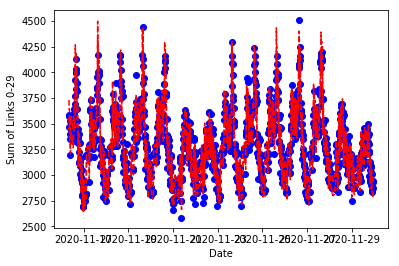

		Quantiles [0.4, 0.6]


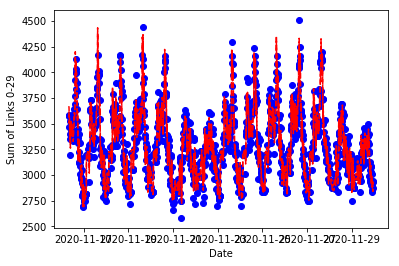

	Summing over 39 links
		Quantiles [0.025, 0.975]


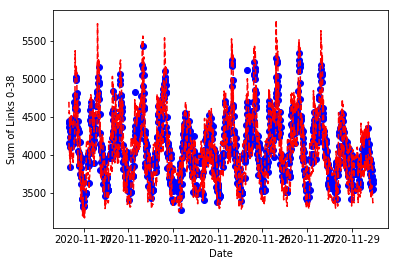

		Quantiles [0.05, 0.95]


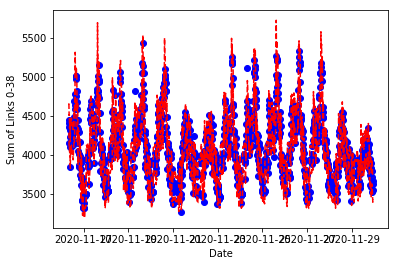

		Quantiles [0.1, 0.9]


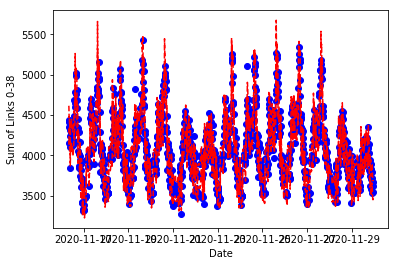

		Quantiles [0.2, 0.8]


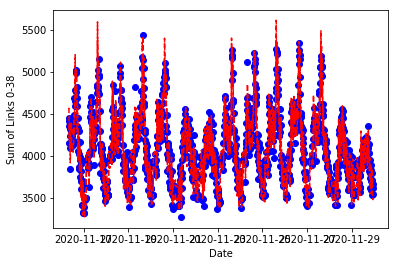

		Quantiles [0.4, 0.6]


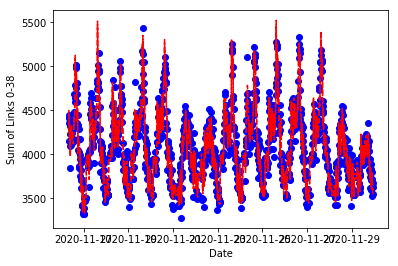

Predicting for t + 30 minutes
	Summing over 1 links
		Quantiles [0.025, 0.975]


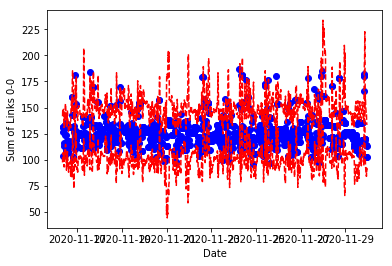

		Quantiles [0.05, 0.95]


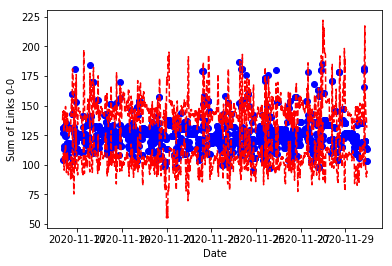

		Quantiles [0.1, 0.9]


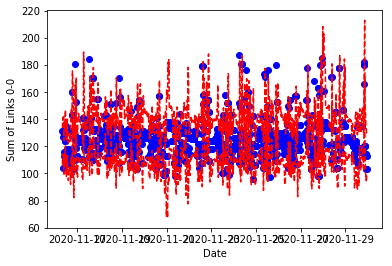

		Quantiles [0.2, 0.8]


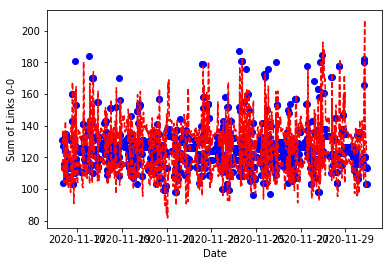

		Quantiles [0.4, 0.6]


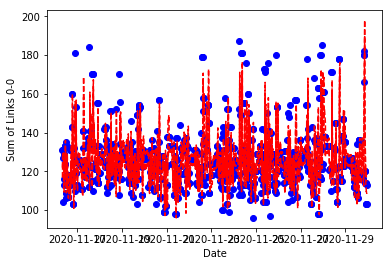

	Summing over 5 links
		Quantiles [0.025, 0.975]


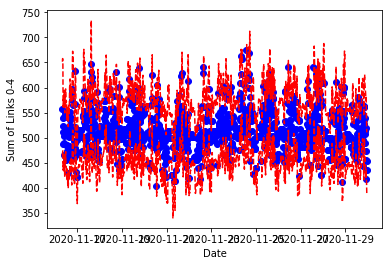

		Quantiles [0.05, 0.95]


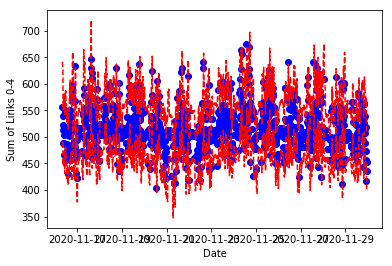

		Quantiles [0.1, 0.9]


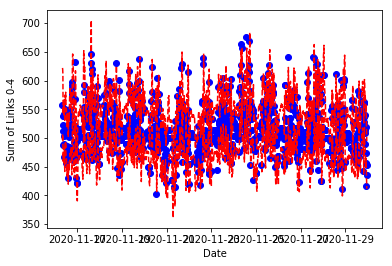

		Quantiles [0.2, 0.8]


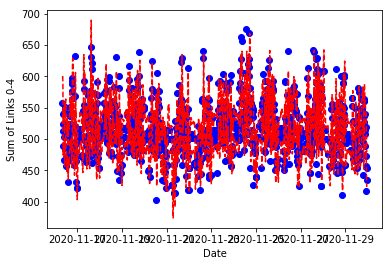

		Quantiles [0.4, 0.6]


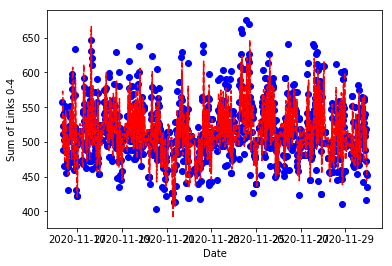

	Summing over 10 links
		Quantiles [0.025, 0.975]


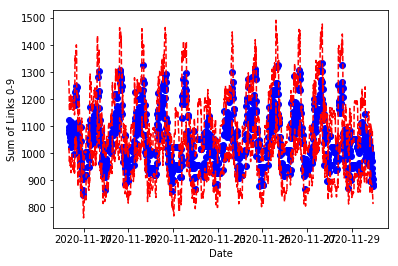

		Quantiles [0.05, 0.95]


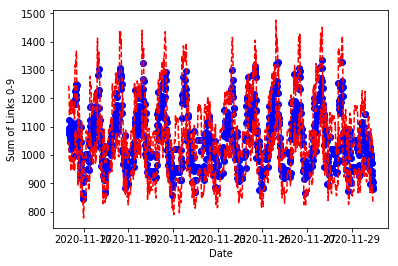

		Quantiles [0.1, 0.9]


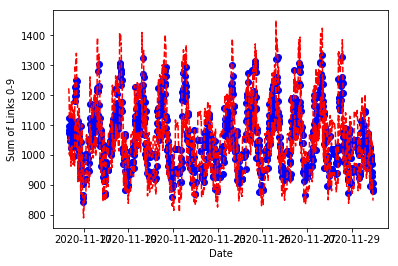

		Quantiles [0.2, 0.8]


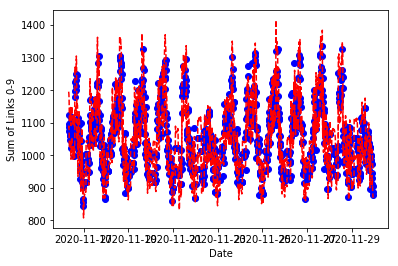

		Quantiles [0.4, 0.6]


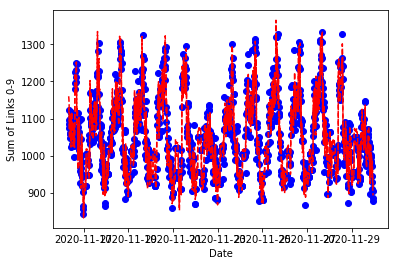

	Summing over 20 links
		Quantiles [0.025, 0.975]


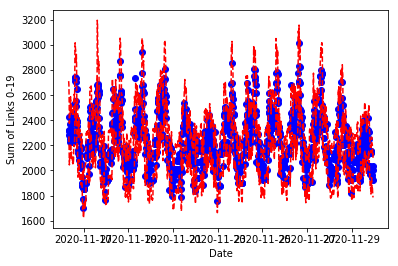

		Quantiles [0.05, 0.95]


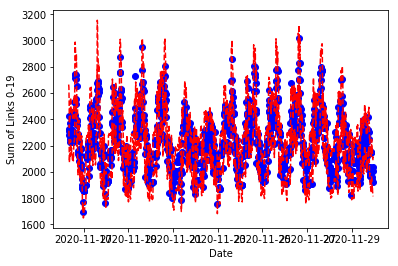

		Quantiles [0.1, 0.9]


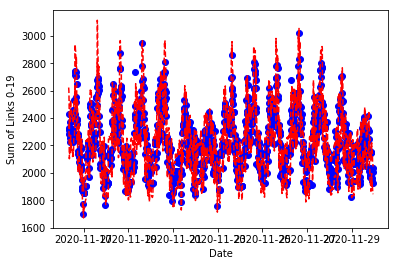

		Quantiles [0.2, 0.8]


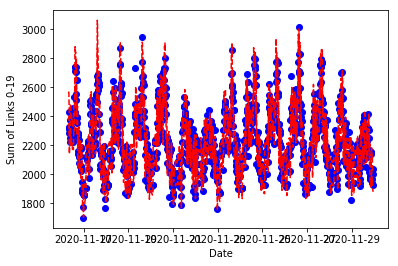

		Quantiles [0.4, 0.6]


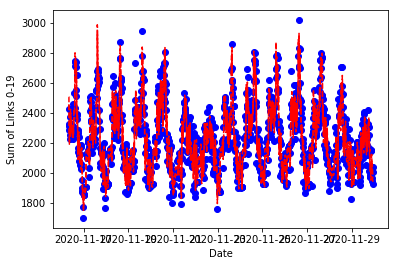

	Summing over 30 links
		Quantiles [0.025, 0.975]


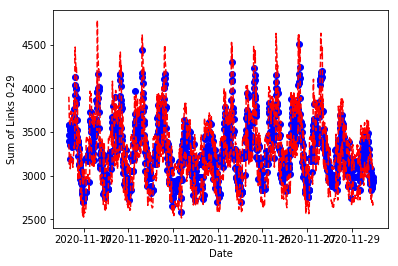

		Quantiles [0.05, 0.95]


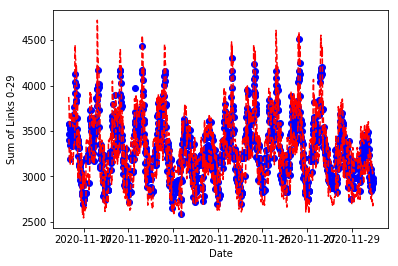

		Quantiles [0.1, 0.9]


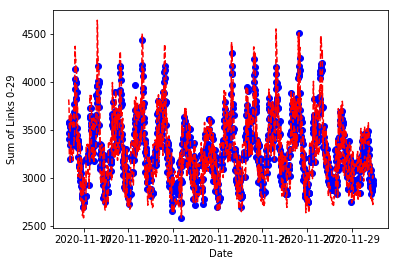

		Quantiles [0.2, 0.8]


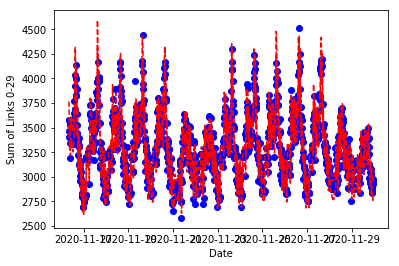

		Quantiles [0.4, 0.6]


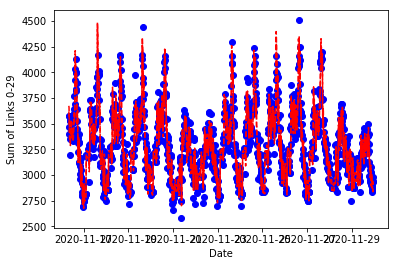

	Summing over 39 links
		Quantiles [0.025, 0.975]


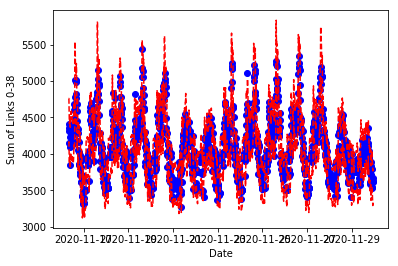

		Quantiles [0.05, 0.95]


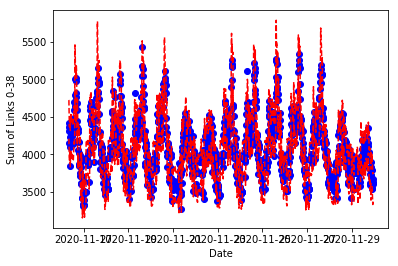

		Quantiles [0.1, 0.9]


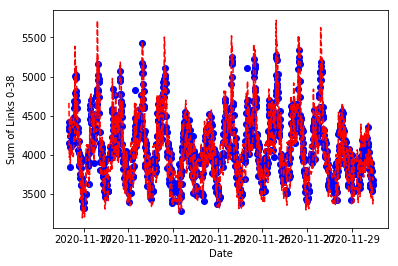

		Quantiles [0.2, 0.8]


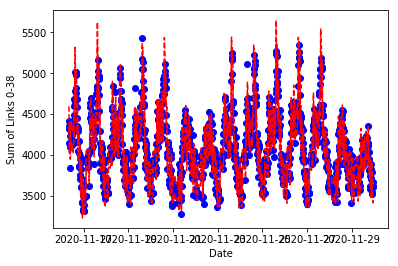

		Quantiles [0.4, 0.6]


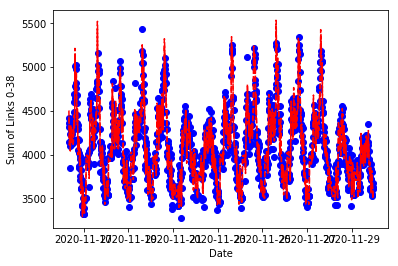

Predicting for t + 45 minutes
	Summing over 1 links
		Quantiles [0.025, 0.975]


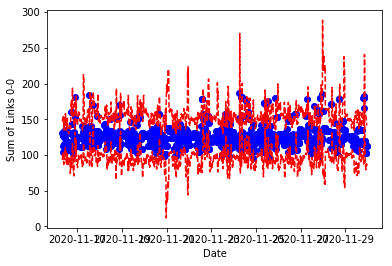

		Quantiles [0.05, 0.95]


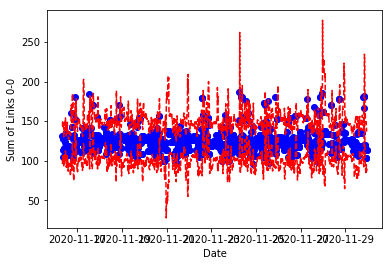

		Quantiles [0.1, 0.9]


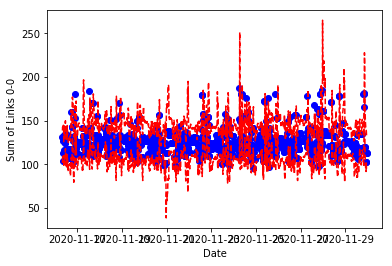

		Quantiles [0.2, 0.8]


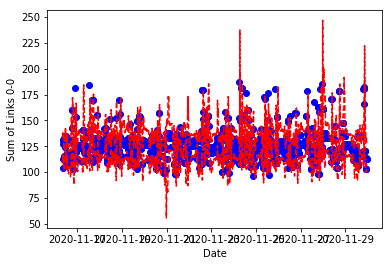

		Quantiles [0.4, 0.6]


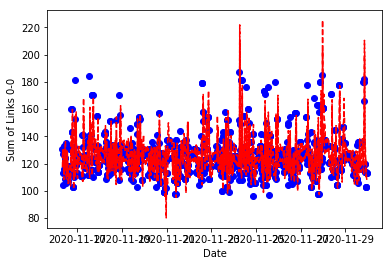

	Summing over 5 links
		Quantiles [0.025, 0.975]


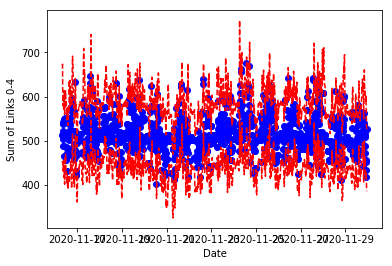

		Quantiles [0.05, 0.95]


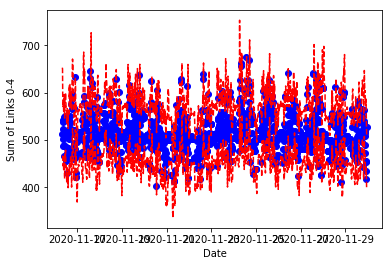

		Quantiles [0.1, 0.9]


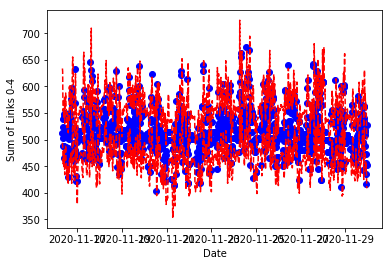

		Quantiles [0.2, 0.8]


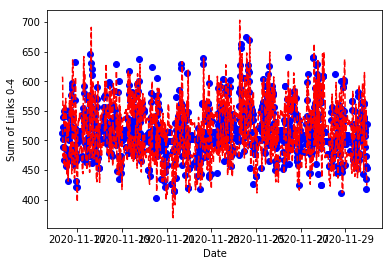

		Quantiles [0.4, 0.6]


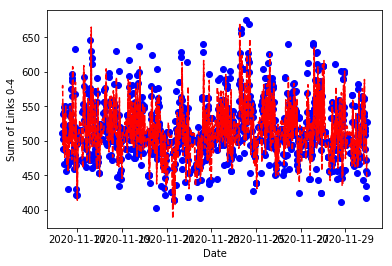

	Summing over 10 links
		Quantiles [0.025, 0.975]


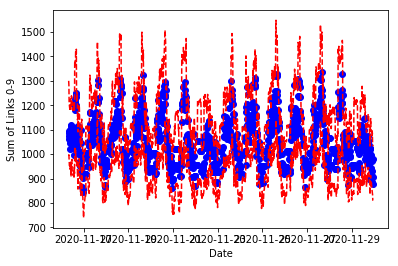

		Quantiles [0.05, 0.95]


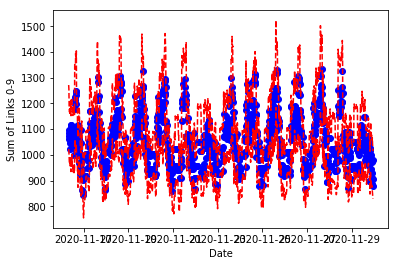

		Quantiles [0.1, 0.9]


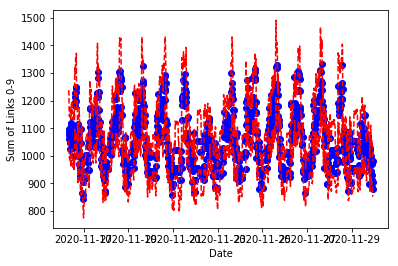

		Quantiles [0.2, 0.8]


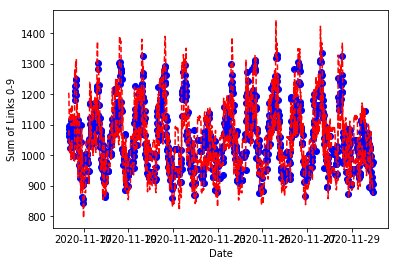

		Quantiles [0.4, 0.6]


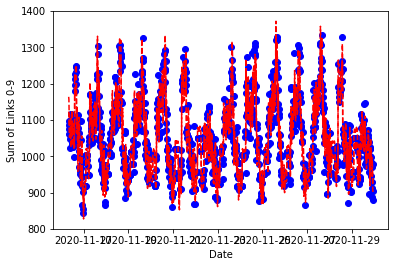

	Summing over 20 links
		Quantiles [0.025, 0.975]


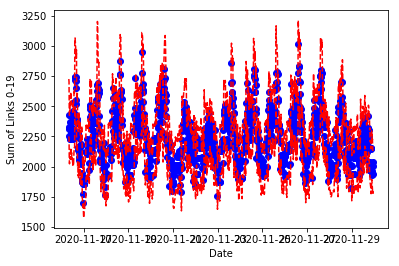

		Quantiles [0.05, 0.95]


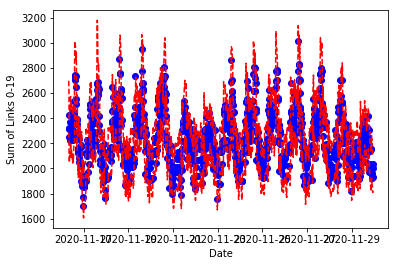

		Quantiles [0.1, 0.9]


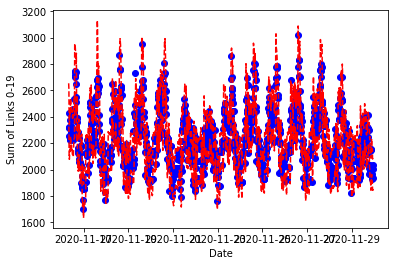

		Quantiles [0.2, 0.8]


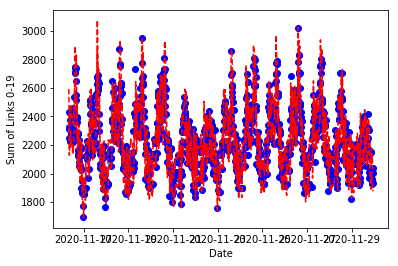

		Quantiles [0.4, 0.6]


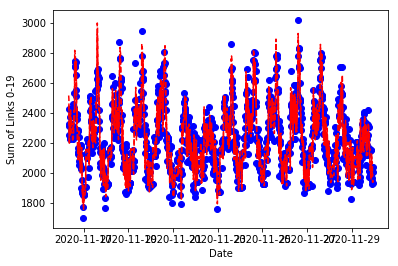

	Summing over 30 links
		Quantiles [0.025, 0.975]


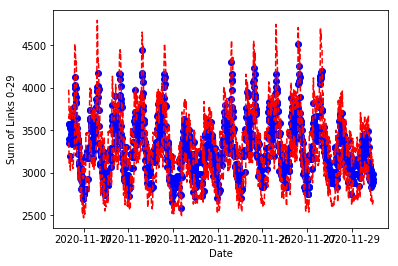

		Quantiles [0.05, 0.95]


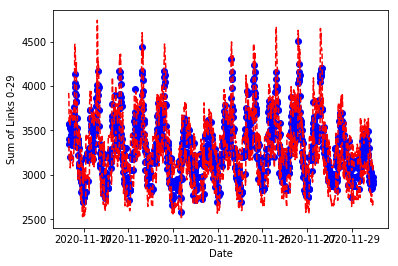

		Quantiles [0.1, 0.9]


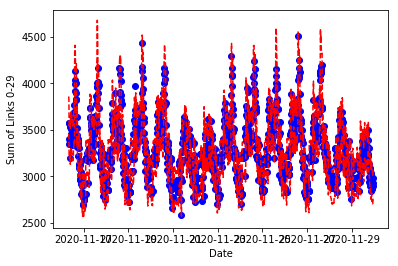

		Quantiles [0.2, 0.8]


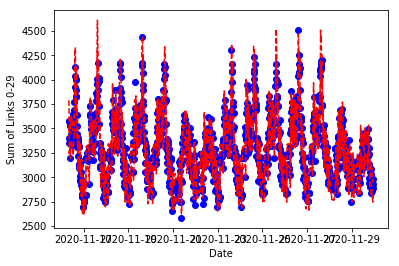

		Quantiles [0.4, 0.6]


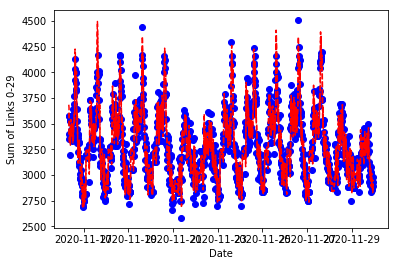

	Summing over 39 links
		Quantiles [0.025, 0.975]


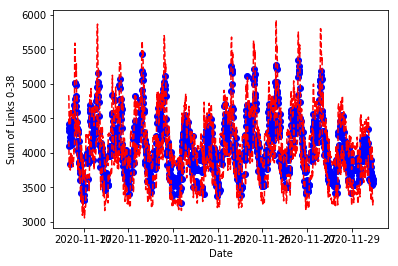

		Quantiles [0.05, 0.95]


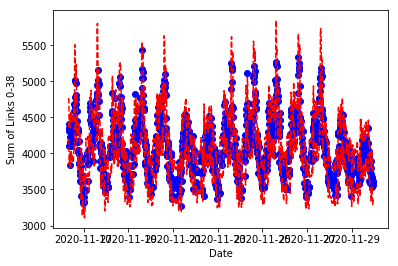

		Quantiles [0.1, 0.9]


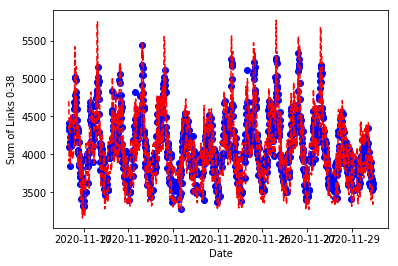

		Quantiles [0.2, 0.8]


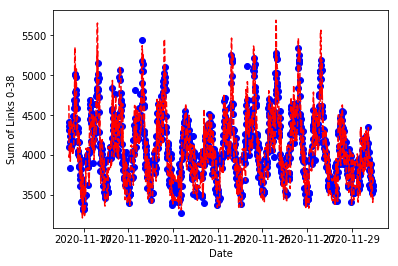

		Quantiles [0.4, 0.6]


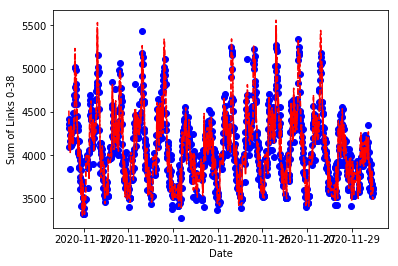

In [20]:
start_lnk = 0
add_lnks = [1, 5, 10, 20, 30, 39]
t_out = [15, 30, 45]

res_dict = {}
for t in range(preds):
    print(f"Predicting for t + {t_out[t]} minutes")
    res_dict[f"t_{t_out[t]}"] = {}
    for add in add_lnks:
        print(f"\tSumming over {add} links")
        res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"] = {}
        links = np.arange(start_lnk, start_lnk+add).astype(int) if add != 100 else np.arange(100)
        for p, pred in enumerate(pred_ints):
            print(f"\t\tQuantiles [{eval_quantiles[2*p]}, {eval_quantiles[2*p+1]}]")
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred] = {}
            
            y_std_test_lnks = np.squeeze(y_std_test[:,t])
            y_mean_test_lnks = np.squeeze(y_mean_test[:,t])
            y_test_back = np.squeeze(y_test[:,t])*y_std_test_lnks + y_mean_test_lnks
            y_test_sum_links = np.sum(y_test_back[:,links], axis=1)
            y_pred_back = y_pred_mean[:,t]
            y_pred_sum_links = np.sum(y_pred_back[:,links], axis=1)
            
            y_pred_s_all = np.sum(y_pred_s[:, :, t, links]*y_std_test[:,t, links] + y_mean_test[:,t,links], axis=2)
            q1 = np.quantile(y_pred_s_all, eval_quantiles[2*p], axis=0)
            q2 = np.quantile(y_pred_s_all, eval_quantiles[2*p+1], axis=0)
            
            plt.plot(y_ix_test, y_test_sum_links, 'bo')
            plt.plot(y_ix_test, q1, 'r--')
            plt.plot(y_ix_test, q2, 'r--')
            plt.xlabel("Date")
            plt.ylabel(f"Sum of Links {np.min(links)}-{np.max(links)}")
            plt.show()
            
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred][f'ICP'] = np.mean(np.logical_and(y_test_sum_links > q1, y_test_sum_links < q2))
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred][f'MIL'] = np.sum(np.maximum(0, q2 - q1)) / len(y_test)
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred][f'RMSE'] = np.sqrt(np.mean((y_pred_sum_links - y_test_sum_links) ** 2))

In [21]:
with open('kalman_results.json', 'w') as fp:
    json.dump(res_dict, fp)

In [22]:
y_pred_mean.shape

(1309, 3, 39)

In [25]:
y_test_sum.shape

(1309, 3)

In [26]:
y_test_sum = np.sum(y_test*y_std_test + y_mean_test, axis=2)
y_pred_mean_sum = np.sum(y_pred_mean*y_std_test + y_mean_test, axis=2)
for q in range(int(len(eval_quantiles)/2)):
    print(f"{int(np.round(pred_ints[q]*100,0))}\\% ", end='')
    for p in range(preds):
        q1 = y_pred_q[2*q, :, p]
        q2 = y_pred_q[2*q+1, :, p]
        icp=np.mean(np.logical_and(y_test_sum[:,0] > q1, y_test_sum[:,0] < q2))
        mil=(np.sum(np.maximum(0, q2-q1))/len(y_test))
        rmse = np.sqrt(np.mean( (y_pred_mean_sum[:,p] - y_test_sum[:,p])**2 ))
        #rmse = np.sqrt(np.mean((np.mean(y_pred_s_all, axis=0)[:,p]/60 - y_test_sum[:,p]/60)**2))
        if p > 0:
            print(" "*5, end="")
        print(f"& {int(np.round(icp*100, 0))} \\% & {int(np.round(mil))} & ", end='')
        if q == 0:
            print("\multirow{5}{*}{" + f"{rmse:.2f}" + "}", end='')
        if p < 2:
            print()
    if q < 4:
        print(" \\\\ \cline{1-3} \cline{5-6} \cline{8-9}")
    else:
        print(" \\\\ \hline")

95\% & 81 \% & 412 & \multirow{5}{*}{156.92}
     & 87 \% & 525 & \multirow{5}{*}{177.47}
     & 89 \% & 619 & \multirow{5}{*}{182.70} \\ \cline{1-3} \cline{5-6} \cline{8-9}
90\% & 75 \% & 347 & 
     & 80 \% & 442 & 
     & 84 \% & 521 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
80\% & 65 \% & 271 & 
     & 70 \% & 345 & 
     & 75 \% & 407 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
60\% & 49 \% & 178 & 
     & 55 \% & 227 & 
     & 59 \% & 267 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
20\% & 23 \% & 54 & 
     & 25 \% & 68 & 
     & 26 \% & 80 &  \\ \hline
